In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pandas as pd
import geopandas as gpd
from mpl_toolkits import mplot3d
from scipy.stats import spearmanr
import collections

# Generation

In [2]:
#import the generation data
gen_df=pd.read_csv('/net/fs11/d0/emfreese/grid_model/outputs/gen.csv')

#### formatting
row 1 is yyyy_dd_hh
column 1 is generator # (s/a in the generator input file)

#### to do
1. sum each row to get the annual total per generator
2. sum the rows by state in which the generator is located
3. import egrids data
4. subtract the model output by state from the state annual emissions from egrid

#### approach
1. see if the data is linearly correlated or what the relationship is between the model/generation
2. see if a specific type of power plant is off and others are correct
3. see if a specific region of power plant is off

In [27]:
#sum each row to get annual total per generator
model_gen=gen_df.sum(axis=1)
model_gen.columns=['generation']

#get ORIS and Region Name
oris_df=pd.read_csv('../us_data/inputs_generators.csv',usecols=[0,6])

#concatenate the model generation and ORIS files
gmodel_oris_df_raw=pd.concat([model_gen, oris_df],axis=1)
gmodel_oris=gmodel_oris_df_raw.rename(columns={0:'modelgeneration'})

#get generation by plant ORIS from egrid data
egrid_df_raw=pd.read_excel('../us_data/egrid2016_data.xlsx',sheet_name='GEN16', usecols='D, L')
egrid=egrid_df_raw.drop(egrid_df_raw.index[0]).rename(columns={'DOE/EIA ORIS plant or facility code':'ORISCode'})
planttype_df_raw=pd.read_excel('../us_data/egrid2016_data.xlsx',sheet_name='PLNT16', usecols='D, W')
planttype_df=planttype_df_raw.drop(egrid_df_raw.index[0]).rename(columns={'DOE/EIA ORIS plant or facility code':'ORISCode', 
                                                                       'Plant primary coal/oil/gas/ other fossil fuel category':'planttype'})

#sort and group any iterations of the generation/input and emissions files by the ORIS code
gmodel_oris=gmodel_oris.groupby(['ORISCode']).sum()
egrid=egrid.groupby(['ORISCode']).sum()
planttype=planttype_df.set_index(['ORISCode'])
planttype_sort=planttype.sort_values(by="ORISCode")
#concatenate our model and emissions dataframes into one, grouped by ORIS code
gmodel_egrid=pd.concat([gmodel_oris,egrid],axis=1).groupby(['ORISCode']).sum()

#turn all zeroes (just in the modelgeneration) to NAN
gmodel_egrid['modelgeneration'][gmodel_egrid['modelgeneration']==0.] = np.nan
#rename the egrid data column for ease
gmodel_egrid=gmodel_egrid.rename(columns={'Generator annual net generation (MWh)':'egridgeneration'})

In [44]:
#concatenate our plant type and emissions dataframes into one dataframe grouped by ORIS code
gmodel_egrid_planttype=pd.concat((gmodel_egrid,planttype_sort),axis=1)
gmodel_egrid_planttype=gmodel_egrid_planttype.sort_values(['ORISCode'])
#look at the difference by plant type
sortedplants=gmodel_egrid_planttype.groupby(['planttype']).sum()

#get emissions of CO2, SO2 by plant ORIS (annual)
egrid_df_raw=pd.read_excel('../us_data/egrid2016_data.xlsx',sheet_name='PLNT16', usecols='D, AP, AQ')
egrid=egrid_df_raw.drop(egrid_df_raw.index[0]).rename(columns={'DOE/EIA ORIS plant or facility code':'ORISCode'})

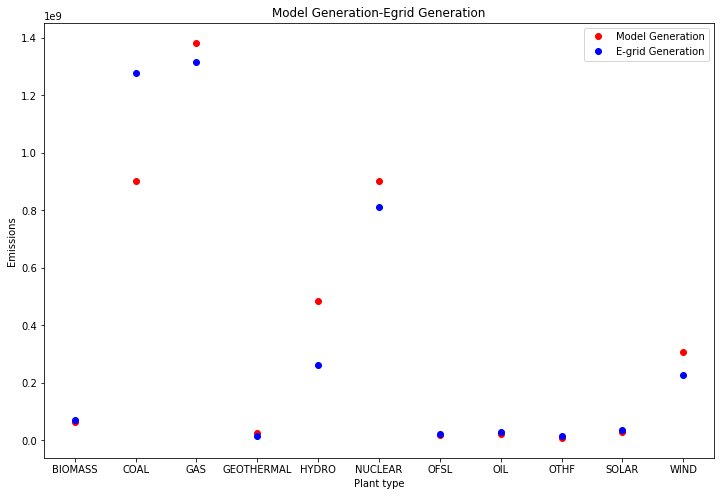

In [47]:

#plot the emissions by plant type to see if some are more accurate than others
fig, ax=plt.subplots(figsize=[12,8])
plt.plot(sortedplants['modelgeneration'],'ro')
x = np.arange(0,10)
plt.plot(sortedplants['egridgeneration'],'bo')
plt.title('Model Generation-Egrid Generation')
plt.xlabel('Plant type')
plt.ylabel('Emissions')
ax.legend(['Model Generation','E-grid Generation'])
plt.savefig('Plant_type_dif_validation')

Biomas, Geothermal, OFSL, Oil, "Other", Solar are all relatively close, its mostly Coal where the model falls short on generation, gas, hydro, nuclear and wind where the model overestimates generation (by more than one order of magnitude)

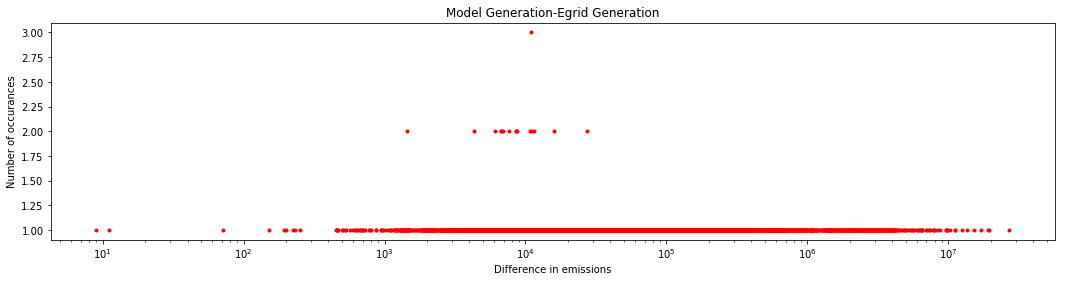

In [49]:
#determine the differences between model and egrid generation
gmodel_dif=np.array(gmodel_egrid['modelgeneration']-gmodel_egrid['egridgeneration'])
#count the occurance of each difference (see what the most common magnitude of dif is)
dif_occurances=collections.Counter(gmodel_dif)
dif_occurances_df=pd.DataFrame.from_dict(dif_occurances,orient='index').reset_index()
dif_occurances_df=dif_occurances_df.rename(columns={'index':'model_egrid_dif',0:'occurance'}).dropna()
#plotting the differences and occurances
fig, ax=plt.subplots(figsize=[18,4])
plt.plot(dif_occurances_df['model_egrid_dif'],dif_occurances_df['occurance'],'r.')
plt.title('Model Generation-Egrid Generation')
plt.xlabel('Difference in emissions')
plt.ylabel('Number of occurances')
plt.xscale('log')
plt.savefig('Ord_of_mag_dif_validation')

Text(0, 0.5, 'emissions')

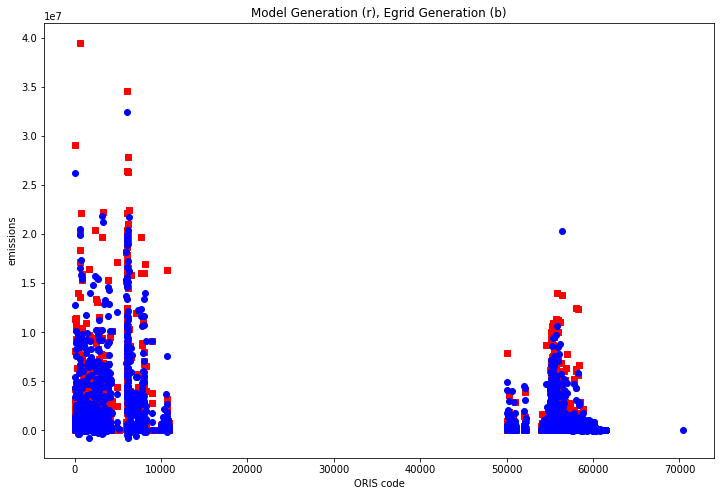

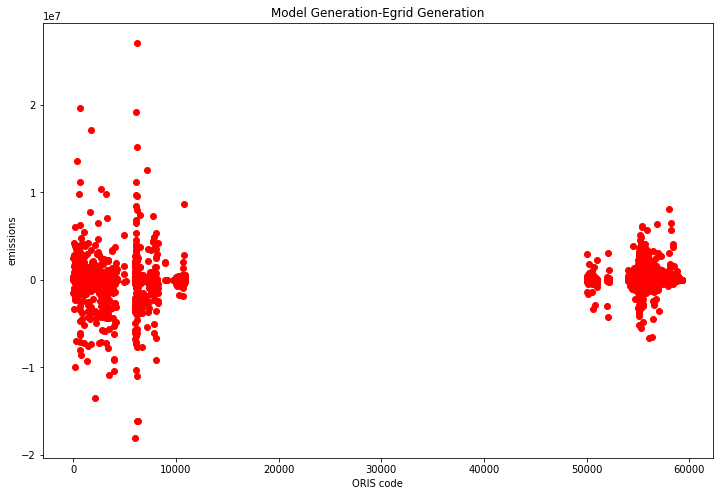

In [158]:
#plot to look at the emissions from both the model and egrid
fig, ax=plt.subplots(figsize=[12,8])
plt.plot(gmodel_egrid['modelgeneration'],'rs')
plt.xlabel('ORIS code')
plt.ylabel('emissions')
plt.plot(gmodel_egrid['egridgeneration'],'bo')
plt.title('Model Generation (r), Egrid Generation (b)')
#plot the difference between the two
fig, ax=plt.subplots(figsize=[12,8])
plt.plot(gmodel_dif,'ro')
plt.title('Model Generation-Egrid Generation')
plt.xlabel('ORIS code')
plt.ylabel('emissions')


# Transmission

In [11]:
trans_df=pd.read_csv('/net/fs11/d0/emfreese/grid_model/outputs/trans.csv')

In [13]:
model_trans=trans_df.sum(axis=1)

In [23]:
#concatenate the model transmission and ORIS files
tmodel_oris_df_raw=pd.concat([model_trans, oris_df],axis=1)
tmodel_oris=tmodel_oris_df_raw.rename(columns={0:'modeltransmission'})